<a href="https://colab.research.google.com/github/Katefarber/LOAMS/blob/main/LOAMS_PythonModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Base Model
Chemical equations and monod constants from Penn and Wang et. al. Quantaties are more qualatative / order of magnitues and may even be unproportional to eachother due to differing values found in litturature.

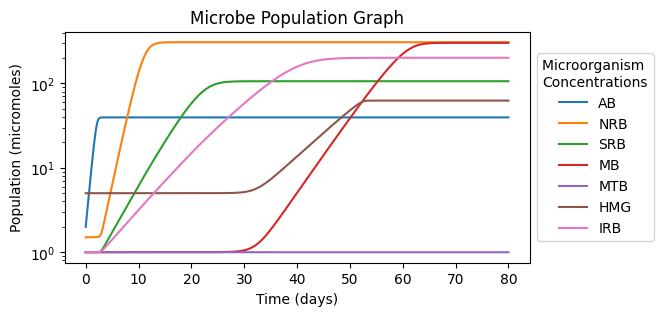

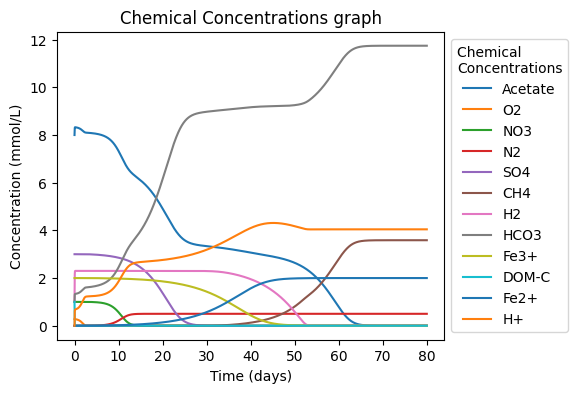

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 0.25 * 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 0.1 * 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Initial values
# Aerobic
acetate0 = 8e-3  # mol/L
o20 = .28e-3  # mol/L
AB0 = 2.0E-6  # mol-bio/L  # aAB

# Denitrifying
no30 = 1.0e-3  # mol/L
n20 = 0.0  # mol/L
NRB0 = 1.5e-6  # mol-bio/L

# Sulfate
so40 = 3.0e-3  # mol/L
SRB0 = 1e-6  # mol-bio/L

# Methanogenesis and Methanotrophy
MB0 = 1e-6  # mol-bio/L (methanogenic biomass)
CH40 = 0.0  # mol/L (methane)
MTB0 = 1e-6  # mol-bio/L (methanotrophic biomass)

# Hydrogenotrophic Methanogenesis
HMG0 = 10 * 5e-7  # mol-bio/L (hydrogenotrophic methanogenic biomass)
H20 = 1e-3  # mol/L (hydrogen)
HCO30 = 1e-3  # mol/L (bicarbonate)

# Iron reduction
fe3p0 = 2.0e-3  # mol/L (Fe3+)
IRB0 = 1.0e-6  # mol-bio/L (iron-reducing biomass)
fe2p0 = 0.0  # mol/L (Fe2+)

# DOM-C initial concentration
domc0 = 1e-3  # mol/L (dissolved organic carbon)

# H+ initial concentration
hplus0 = 0.0  # mol/L (H+)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = 1e-2 * muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) #*iron inhibition
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy =  muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus])

# Time parameters for integration
Nt = 100000
tmax = 80.0
t = np.linspace(0.0, tmax, Nt)

# Initial conditions
X0 = [acetate0, o20, AB0, no30, n20, NRB0, so40, SRB0, MB0, MTB0, HMG0, CH40, H20, HCO30, fe3p0, IRB0, domc0, fe2p0, hplus0]

# Integrate the ODE system
res = odeint(derivative, X0, t)

# Extract and convert concentrations
variables = res.T
microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
chemicals = [variables[0], variables[1], variables[3], variables[4], variables[6], variables[11], variables[12], variables[13], variables[14], variables[16], variables[17], variables[18]]  # Chemical concentrations

# Plotting microbes
plt.figure(figsize=(6, 3))
microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
for i, microbe in enumerate(microbes):
    plt.plot(t, microbe * 1e6, label=microbe_names[i])  # Convert to micromoles
plt.yscale('log')
plt.title("Microbe Population Graph")
plt.xlabel("Time (days)")
plt.ylabel("Population (micromoles)")
plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting chemical concentrations
plt.figure(figsize=(5, 4))
chemical_names = ["Acetate", "O2", "NO3", "N2", "SO4", "CH4", "H2", "HCO3", "Fe3+", "DOM-C", "Fe2+", "H+"]
for i, chemical in enumerate(chemicals):
    plt.plot(t, chemical * 1e3, label=chemical_names[i])  # Convert to mmol/L
plt.title("Chemical Concentrations graph")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


splt graph of donor acceptor pair (dashed and solid) and other (acetate, hco3, h2, h+ and dom-c)

Printing out raw "end values," with ability to add in more "situations."

Scenario 1 final conditions:
Acetate: 0.0000 mmol/L
O2: 0.0000 mmol/L
AB: 39.5200 micromol/L
NO3: 0.0000 mmol/L
N2: 0.5000 mmol/L
NRB: 307.0556 micromol/L
SO4: 0.0000 mmol/L
SRB: 106.0000 micromol/L
MB: 302.1645 micromol/L
MTB: 1.0000 micromol/L
HMG: 62.5000 micromol/L
CH4: 3.5866 mmol/L
H2: 0.0000 mmol/L
HCO3: 11.7466 mmol/L
Fe3+: 0.0002 mmol/L
IRB: 200.9758 micromol/L
DOM-C: -0.0000 mmol/L
Fe2+: 1.9998 mmol/L
H+: 4.0436 mmol/L



Making entering inital condidtions more intuative for user using dictionary/ labling scheme.

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = 0.25 * muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = 0.1 * muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy = 0.1 * muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = 0.1 * muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus])

# Function to run the model and return results at end time
def run_model(initial_conditions, tmax=80.0, Nt=100000):
    t = np.linspace(0.0, tmax, Nt)
    res = odeint(derivative, initial_conditions, t)
    return res[-1]

# Function to convert initial conditions dictionary to list
def convert_initial_conditions_dict_to_list(initial_conditions_dict):
    return [
        initial_conditions_dict['acetate'],
        initial_conditions_dict['o2'],
        initial_conditions_dict['ab'],
        initial_conditions_dict['no3'],
        initial_conditions_dict['n2'],
        initial_conditions_dict['nrb'],
        initial_conditions_dict['so4'],
        initial_conditions_dict['srb'],
        initial_conditions_dict['mb'],
        initial_conditions_dict['mtb'],
        initial_conditions_dict['hmg'],
        initial_conditions_dict['ch4'],
        initial_conditions_dict['h2'],
        initial_conditions_dict['hco3'],
        initial_conditions_dict['fe3p'],
        initial_conditions_dict['irb'],
        initial_conditions_dict['domc'],
        initial_conditions_dict['fe2p'],
        initial_conditions_dict['hplus']
    ]

# Initial conditions for different scenarios
scenarios = [
    {
        'acetate': 8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    # Add more scenarios as needed
]

# Run model for each scenario and display results at end time
for i, scenario in enumerate(scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    final_conditions = run_model(initial_conditions_list)
    print(f"Scenario {i+1} final conditions:")
    print(f"Acetate: {final_conditions[0]*1e3:.4f} mmol/L")
    print(f"O2: {final_conditions[1]*1e3:.4f} mmol/L")
    print(f"AB: {final_conditions[2]*1e6:.4f} micromol/L")
    print(f"NO3: {final_conditions[3]*1e3:.4f} mmol/L")
    print(f"N2: {final_conditions[4]*1e3:.4f} mmol/L")
    print(f"NRB: {final_conditions[5]*1e6:.4f} micromol/L")
    print(f"SO4: {final_conditions[6]*1e3:.4f} mmol/L")
    print(f"SRB: {final_conditions[7]*1e6:.4f} micromol/L")
    print(f"MB: {final_conditions[8]*1e6:.4f} micromol/L")
    print(f"MTB: {final_conditions[9]*1e6:.4f} micromol/L")
    print(f"HMG: {final_conditions[10]*1e6:.4f} micromol/L")
    print(f"CH4: {final_conditions[11]*1e3:.4f} mmol/L")
    print(f"H2: {final_conditions[12]*1e3:.4f} mmol/L")
    print(f"HCO3: {final_conditions[13]*1e3:.4f} mmol/L")
    print(f"Fe3+: {final_conditions[14]*1e3:.4f} mmol/L")
    print(f"IRB: {final_conditions[15]*1e6:.4f} micromol/L")
    print(f"DOM-C: {final_conditions[16]*1e3:.4f} mmol/L")
    print(f"Fe2+: {final_conditions[17]*1e3:.4f} mmol/L")
    print(f"H+: {final_conditions[18]*1e3:.4f} mmol/L")
    print()


Scenario 1 final conditions:
Acetate: 0.0000 mmol/L
O2: 0.0000 mmol/L
AB: 39.5200 micromol/L
NO3: 0.0000 mmol/L
N2: 0.5000 mmol/L
NRB: 307.0556 micromol/L
SO4: 0.0000 mmol/L
SRB: 106.0000 micromol/L
MB: 302.1645 micromol/L
MTB: 1.0000 micromol/L
HMG: 62.5000 micromol/L
CH4: 3.5866 mmol/L
H2: 0.0000 mmol/L
HCO3: 11.7466 mmol/L
Fe3+: 0.0002 mmol/L
IRB: 200.9758 micromol/L
DOM-C: -0.0000 mmol/L
Fe2+: 1.9998 mmol/L
H+: 4.0436 mmol/L



Example of graphing "end values," while varying inital conditions in this case for acetate and methane.

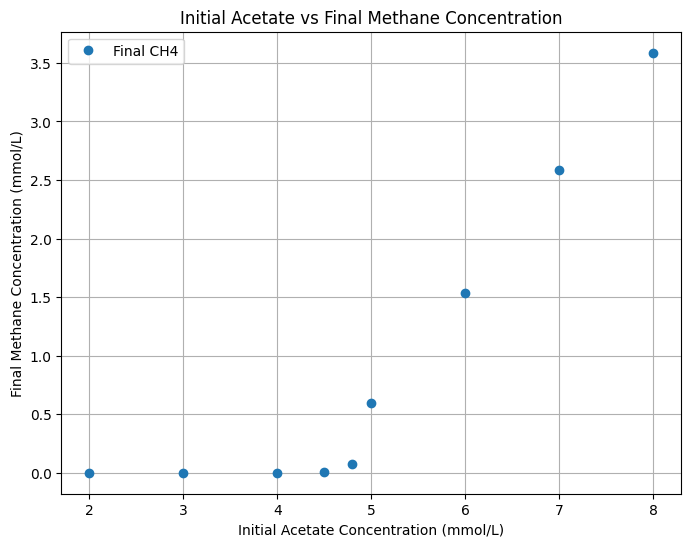

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = 0.25 * muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = 0.1 * muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy = 0.1 * muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = 0.1 * muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus])

# Function to run the model and return results at end time
def run_model(initial_conditions, tmax=80.0, Nt=100000):
    t = np.linspace(0.0, tmax, Nt)
    res = odeint(derivative, initial_conditions, t)
    return res[-1]

# Function to convert initial conditions dictionary to list
def convert_initial_conditions_dict_to_list(initial_conditions_dict):
    return [
        initial_conditions_dict['acetate'],
        initial_conditions_dict['o2'],
        initial_conditions_dict['ab'],
        initial_conditions_dict['no3'],
        initial_conditions_dict['n2'],
        initial_conditions_dict['nrb'],
        initial_conditions_dict['so4'],
        initial_conditions_dict['srb'],
        initial_conditions_dict['mb'],
        initial_conditions_dict['mtb'],
        initial_conditions_dict['hmg'],
        initial_conditions_dict['ch4'],
        initial_conditions_dict['h2'],
        initial_conditions_dict['hco3'],
        initial_conditions_dict['fe3p'],
        initial_conditions_dict['irb'],
        initial_conditions_dict['domc'],
        initial_conditions_dict['fe2p'],
        initial_conditions_dict['hplus']
    ]

# Initial conditions for different scenarios
scenarios = [
    {
        'acetate': 8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 4e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 3e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 2e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 4.5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 4.8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 6e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 7e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
]

# Store the results
initial_acetate_concentrations = []
final_methane_concentrations = []

# Run model for each scenario and store the results
for i, scenario in enumerate(scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    final_conditions = run_model(initial_conditions_list)
    initial_acetate_concentrations.append(scenario['acetate'] * 1e3)  # Convert to mmol/L for plotting
    final_methane_concentrations.append(final_conditions[11] * 1e3)  # Convert to mmol/L for plotting

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(initial_acetate_concentrations, final_methane_concentrations, 'o', label='Final CH4')
plt.xlabel("Initial Acetate Concentration (mmol/L)")
plt.ylabel("Final Methane Concentration (mmol/L)")
plt.title("Initial Acetate vs Final Methane Concentration")
plt.legend()
plt.grid(True)
plt.show()


Graphing onset of methane production (when methane concetration exceedes 1mmol/L) with varying acetate concetrations.

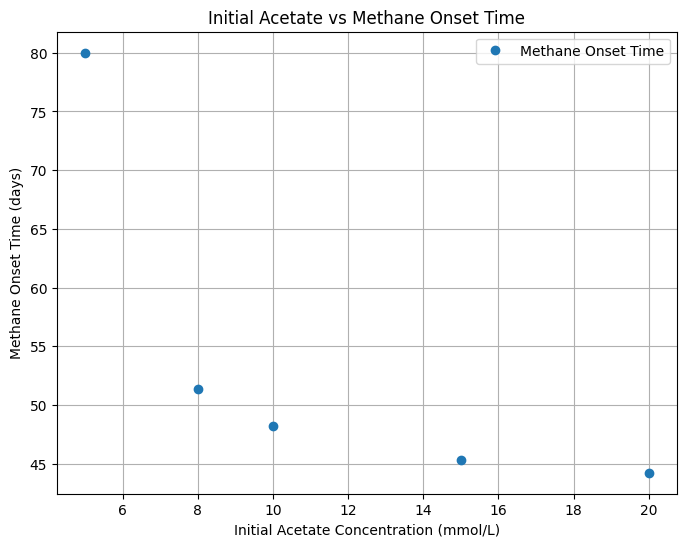

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = 0.25 * muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = 0.1 * muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy = 0.1 * muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = 0.1 * muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus])

# Function to run the model and return results
def run_model_with_onset_time(initial_conditions, tmax=80.0, Nt=100000):
    t = np.linspace(0.0, tmax, Nt)
    res = odeint(derivative, initial_conditions, t)
    methane = res[:, 11]
    onset_time = next((time for time, ch4 in zip(t, methane) if ch4 > 1e-3), tmax)  # Methane onset time in days
    return onset_time, res

# Function to convert initial conditions dictionary to list
def convert_initial_conditions_dict_to_list(initial_conditions_dict):
    return [
        initial_conditions_dict['acetate'],
        initial_conditions_dict['o2'],
        initial_conditions_dict['ab'],
        initial_conditions_dict['no3'],
        initial_conditions_dict['n2'],
        initial_conditions_dict['nrb'],
        initial_conditions_dict['so4'],
        initial_conditions_dict['srb'],
        initial_conditions_dict['mb'],
        initial_conditions_dict['mtb'],
        initial_conditions_dict['hmg'],
        initial_conditions_dict['ch4'],
        initial_conditions_dict['h2'],
        initial_conditions_dict['hco3'],
        initial_conditions_dict['fe3p'],
        initial_conditions_dict['irb'],
        initial_conditions_dict['domc'],
        initial_conditions_dict['fe2p'],
        initial_conditions_dict['hplus']
    ]

# Initial conditions for different scenarios
scenarios = [
    {
        'acetate': 8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 10e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 15e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 20e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
]

# Store the results
initial_acetate_concentrations = []
methane_onset_times = []

# Run model for each scenario and store the results
for i, scenario in enumerate(scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    onset_time, _ = run_model_with_onset_time(initial_conditions_list)
    initial_acetate_concentrations.append(scenario['acetate'] * 1e3)  # Convert to mmol/L for plotting
    methane_onset_times.append(onset_time)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(initial_acetate_concentrations, methane_onset_times, 'o', label='Methane Onset Time')
plt.xlabel("Initial Acetate Concentration (mmol/L)")
plt.ylabel("Methane Onset Time (days)")
plt.title("Initial Acetate vs Methane Onset Time")
plt.legend()
plt.grid(True)
plt.show()


Example of multiple varying initial conditions to look at methane onset. (DOM and Acetate).

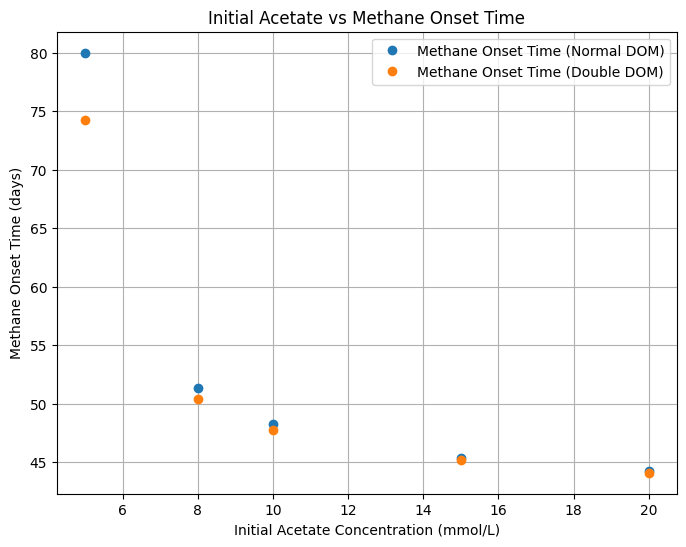

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = 0.25 * muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = 0.1 * muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy = 0.1 * muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = 0.1 * muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus])

# Function to run the model and return results
def run_model_with_onset_time(initial_conditions, tmax=80.0, Nt=100000):
    t = np.linspace(0.0, tmax, Nt)
    res = odeint(derivative, initial_conditions, t)
    methane = res[:, 11]
    onset_time = next((time for time, ch4 in zip(t, methane) if ch4 > 1e-3), tmax)  # Methane onset time in days
    return onset_time, res

# Function to convert initial conditions dictionary to list
def convert_initial_conditions_dict_to_list(initial_conditions_dict):
    return [
        initial_conditions_dict['acetate'],
        initial_conditions_dict['o2'],
        initial_conditions_dict['ab'],
        initial_conditions_dict['no3'],
        initial_conditions_dict['n2'],
        initial_conditions_dict['nrb'],
        initial_conditions_dict['so4'],
        initial_conditions_dict['srb'],
        initial_conditions_dict['mb'],
        initial_conditions_dict['mtb'],
        initial_conditions_dict['hmg'],
        initial_conditions_dict['ch4'],
        initial_conditions_dict['h2'],
        initial_conditions_dict['hco3'],
        initial_conditions_dict['fe3p'],
        initial_conditions_dict['irb'],
        initial_conditions_dict['domc'],
        initial_conditions_dict['fe2p'],
        initial_conditions_dict['hplus']
    ]

# Initial conditions for different scenarios
scenarios = [
    {
        'acetate': 8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 10e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 15e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 20e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
]

# Double DOM scenarios
double_dom_scenarios = [
    {**scenario, 'domc': scenario['domc'] * 2} for scenario in scenarios
]

# Store the results
initial_acetate_concentrations = []
methane_onset_times = []
double_dom_methane_onset_times = []

# Run model for each scenario and store the results
for i, scenario in enumerate(scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    onset_time, _ = run_model_with_onset_time(initial_conditions_list)
    initial_acetate_concentrations.append(scenario['acetate'] * 1e3)  # Convert to mmol/L for plotting
    methane_onset_times.append(onset_time)

# Run model for each double DOM scenario and store the results
for i, scenario in enumerate(double_dom_scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    onset_time, _ = run_model_with_onset_time(initial_conditions_list)
    double_dom_methane_onset_times.append(onset_time)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(initial_acetate_concentrations, methane_onset_times, 'o', label='Methane Onset Time (Normal DOM)')
plt.plot(initial_acetate_concentrations, double_dom_methane_onset_times, 'o', label='Methane Onset Time (Double DOM)')
plt.xlabel("Initial Acetate Concentration (mmol/L)")
plt.ylabel("Methane Onset Time (days)")
plt.title("Initial Acetate vs Methane Onset Time")
plt.legend()
plt.grid(True)
plt.show()


mu max better (putting multipliers into mu max var instead of in rate)- same reesults, but more readable

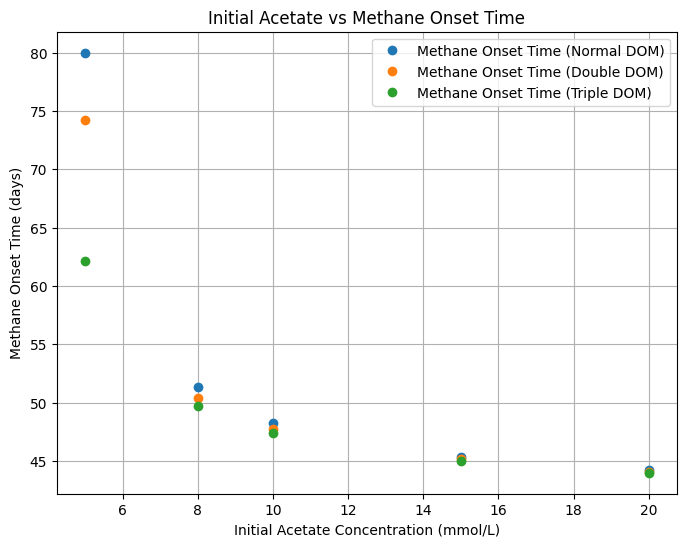

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 0.25 * 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 0.1 * 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy = muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus])

# Function to run the model and return results
def run_model_with_onset_time(initial_conditions, tmax=80.0, Nt=100000):
    t = np.linspace(0.0, tmax, Nt)
    res = odeint(derivative, initial_conditions, t)
    methane = res[:, 11]
    onset_time = next((time for time, ch4 in zip(t, methane) if ch4 > 1e-3), tmax)  # Methane onset time in days
    return onset_time, res

# Function to convert initial conditions dictionary to list
def convert_initial_conditions_dict_to_list(initial_conditions_dict):
    return [
        initial_conditions_dict['acetate'],
        initial_conditions_dict['o2'],
        initial_conditions_dict['ab'],
        initial_conditions_dict['no3'],
        initial_conditions_dict['n2'],
        initial_conditions_dict['nrb'],
        initial_conditions_dict['so4'],
        initial_conditions_dict['srb'],
        initial_conditions_dict['mb'],
        initial_conditions_dict['mtb'],
        initial_conditions_dict['hmg'],
        initial_conditions_dict['ch4'],
        initial_conditions_dict['h2'],
        initial_conditions_dict['hco3'],
        initial_conditions_dict['fe3p'],
        initial_conditions_dict['irb'],
        initial_conditions_dict['domc'],
        initial_conditions_dict['fe2p'],
        initial_conditions_dict['hplus']
    ]

# Initial conditions for different scenarios
scenarios = [
    {
        'acetate': 8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 10e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 15e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
    {
        'acetate': 20e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0
    },
]

# Double DOM scenarios
double_dom_scenarios = [
    {**scenario, 'domc': scenario['domc'] * 2} for scenario in scenarios
]

# Triple DOM scenarios
triple_dom_scenarios = [
    {**scenario, 'domc': scenario['domc'] * 3} for scenario in scenarios
]

# Store the results
initial_acetate_concentrations = []
methane_onset_times = []
double_dom_methane_onset_times = []
triple_dom_methane_onset_times = []

# Run model for each scenario and store the results
for i, scenario in enumerate(scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    onset_time, _ = run_model_with_onset_time(initial_conditions_list)
    initial_acetate_concentrations.append(scenario['acetate'] * 1e3)  # Convert to mmol/L for plotting
    methane_onset_times.append(onset_time)

# Run model for each double DOM scenario and store the results
for i, scenario in enumerate(double_dom_scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    onset_time, _ = run_model_with_onset_time(initial_conditions_list)
    double_dom_methane_onset_times.append(onset_time)

# Run model for each triple DOM scenario and store the results
for i, scenario in enumerate(triple_dom_scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    onset_time, _ = run_model_with_onset_time(initial_conditions_list)
    triple_dom_methane_onset_times.append(onset_time)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(initial_acetate_concentrations, methane_onset_times, 'o', label='Methane Onset Time (Normal DOM)')
plt.plot(initial_acetate_concentrations, double_dom_methane_onset_times, 'o', label='Methane Onset Time (Double DOM)')
plt.plot(initial_acetate_concentrations, triple_dom_methane_onset_times, 'o', label='Methane Onset Time (Triple DOM)')
plt.xlabel("Initial Acetate Concentration (mmol/L)")
plt.ylabel("Methane Onset Time (days)")
plt.title("Initial Acetate vs Methane Onset Time")
plt.legend()
plt.grid(True)
plt.show()


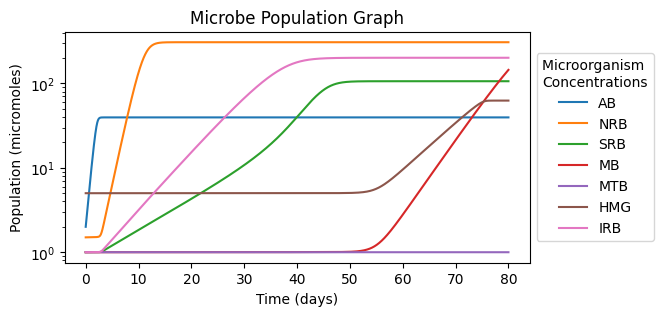

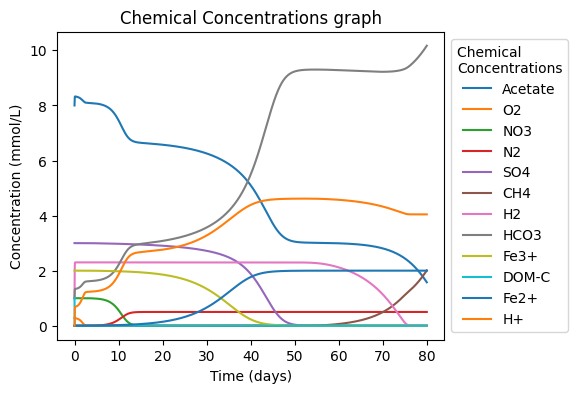

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 0.25 * 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
kironi = 1e-3  # Inhibition constant for iron in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 0.1 * 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Initial values
# Aerobic
acetate0 = 8e-3  # mol/L
o20 = .28e-3  # mol/L
AB0 = 2.0E-6  # mol-bio/L  # aAB

# Denitrifying
no30 = 1.0e-3  # mol/L
n20 = 0.0  # mol/L
NRB0 = 1.5e-6  # mol-bio/L

# Sulfate
so40 = 3.0e-3  # mol/L
SRB0 = 1e-6  # mol-bio/L

# Methanogenesis and Methanotrophy
MB0 = 1e-6  # mol-bio/L (methanogenic biomass)
CH40 = 0.0  # mol/L (methane)
MTB0 = 1e-6  # mol-bio/L (methanotrophic biomass)

# Hydrogenotrophic Methanogenesis
HMG0 = 10 * 5e-7  # mol-bio/L (hydrogenotrophic methanogenic biomass)
H20 = 1e-3  # mol/L (hydrogen)
HCO30 = 1e-3  # mol/L (bicarbonate)

# Iron reduction
fe3p0 = 2.0e-3  # mol/L (Fe3+)
IRB0 = 1.0e-6  # mol-bio/L (iron-reducing biomass)
fe2p0 = 0.0  # mol/L (Fe2+)

# DOM-C initial concentration
domc0 = 1e-3  # mol/L (dissolved organic carbon)

# H+ initial concentration
hplus0 = 0.0  # mol/L (H+)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = 1e-2 * muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) * (kironi / (kironi + fe3p))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy =  muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus])

# Time parameters for integration
Nt = 100000
tmax = 80.0
t = np.linspace(0.0, tmax, Nt)

# Initial conditions
X0 = [acetate0, o20, AB0, no30, n20, NRB0, so40, SRB0, MB0, MTB0, HMG0, CH40, H20, HCO30, fe3p0, IRB0, domc0, fe2p0, hplus0]

# Integrate the ODE system
res = odeint(derivative, X0, t)

# Extract and convert concentrations
variables = res.T
microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
chemicals = [variables[0], variables[1], variables[3], variables[4], variables[6], variables[11], variables[12], variables[13], variables[14], variables[16], variables[17], variables[18]]  # Chemical concentrations

# Plotting microbes
plt.figure(figsize=(6, 3))
microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
for i, microbe in enumerate(microbes):
    plt.plot(t, microbe * 1e6, label=microbe_names[i])  # Convert to micromoles
plt.yscale('log')
plt.title("Microbe Population Graph")
plt.xlabel("Time (days)")
plt.ylabel("Population (micromoles)")
plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting chemical concentrations
plt.figure(figsize=(5, 4))
chemical_names = ["Acetate", "O2", "NO3", "N2", "SO4", "CH4", "H2", "HCO3", "Fe3+", "DOM-C", "Fe2+", "H+"]
for i, chemical in enumerate(chemicals):
    plt.plot(t, chemical * 1e3, label=chemical_names[i])  # Convert to mmol/L
plt.title("Chemical Concentrations graph")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


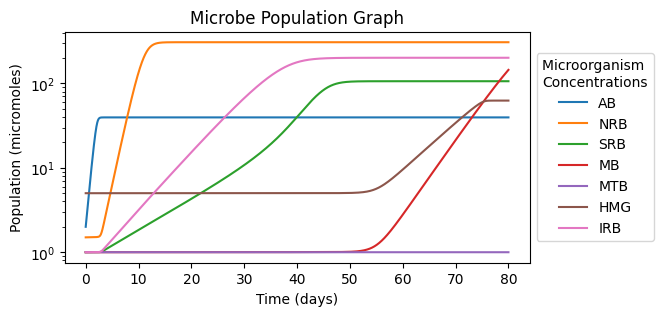

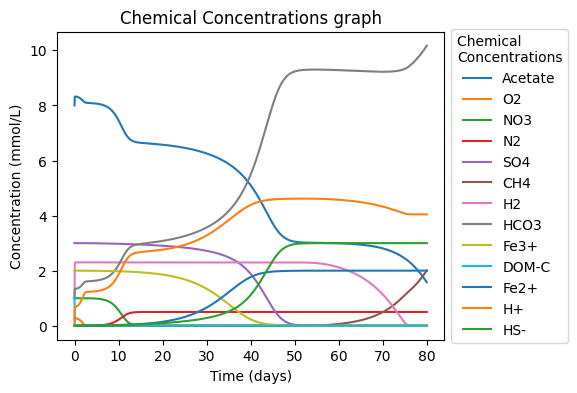

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 0.25 * 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
kironi = 1e-3  # Inhibition constant for iron in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 0.1 * 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Initial values
# Aerobic
acetate0 = 8e-3  # mol/L
o20 = .28e-3  # mol/L
AB0 = 2.0E-6  # mol-bio/L  # aAB

# Denitrifying
no30 = 1.0e-3  # mol/L
n20 = 0.0  # mol/L
NRB0 = 1.5e-6  # mol-bio/L

# Sulfate
so40 = 3.0e-3  # mol/L
SRB0 = 1e-6  # mol-bio/L
HS0 = 0.0  # mol/L (initial HS- concentration)

# Methanogenesis and Methanotrophy
MB0 = 1e-6  # mol-bio/L (methanogenic biomass)
CH40 = 0.0  # mol/L (methane)
MTB0 = 1e-6  # mol-bio/L (methanotrophic biomass)

# Hydrogenotrophic Methanogenesis
HMG0 = 10 * 5e-7  # mol-bio/L (hydrogenotrophic methanogenic biomass)
H20 = 1e-3  # mol/L (hydrogen)
HCO30 = 1e-3  # mol/L (bicarbonate)

# Iron reduction
fe3p0 = 2.0e-3  # mol/L (Fe3+)
IRB0 = 1.0e-6  # mol-bio/L (iron-reducing biomass)
fe2p0 = 0.0  # mol/L (Fe2+)

# DOM-C initial concentration
domc0 = 1e-3  # mol/L (dissolved organic carbon)

# H+ initial concentration
hplus0 = 0.0  # mol/L (H+)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus, hs = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0
    dHS = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = 1e-2 * muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) * (kironi / (kironi + fe3p))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction
    dHS += 0.125 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy =  muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus, dHS])

# Time parameters for integration
Nt = 100000
tmax = 80.0
t = np.linspace(0.0, tmax, Nt)

# Initial conditions
X0 = [acetate0, o20, AB0, no30, n20, NRB0, so40, SRB0, MB0, MTB0, HMG0, CH40, H20, HCO30, fe3p0, IRB0, domc0, fe2p0, hplus0, HS0]

# Integrate the ODE system
res = odeint(derivative, X0, t)

# Extract and convert concentrations
variables = res.T
microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
chemicals = [variables[0], variables[1], variables[3], variables[4], variables[6], variables[11], variables[12], variables[13], variables[14], variables[16], variables[17], variables[18], variables[19]]  # Chemical concentrations

# Plotting microbes
plt.figure(figsize=(6, 3))
microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
for i, microbe in enumerate(microbes):
    plt.plot(t, microbe * 1e6, label=microbe_names[i])  # Convert to micromoles
plt.yscale('log')
plt.title("Microbe Population Graph")
plt.xlabel("Time (days)")
plt.ylabel("Population (micromoles)")
plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting chemical concentrations
plt.figure(figsize=(5, 4))
chemical_names = ["Acetate", "O2", "NO3", "N2", "SO4", "CH4", "H2", "HCO3", "Fe3+", "DOM-C", "Fe2+", "H+", "HS-"]
for i, chemical in enumerate(chemicals):
    plt.plot(t, chemical * 1e3, label=chemical_names[i])  # Convert to mmol/L
plt.title("Chemical Concentrations graph")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


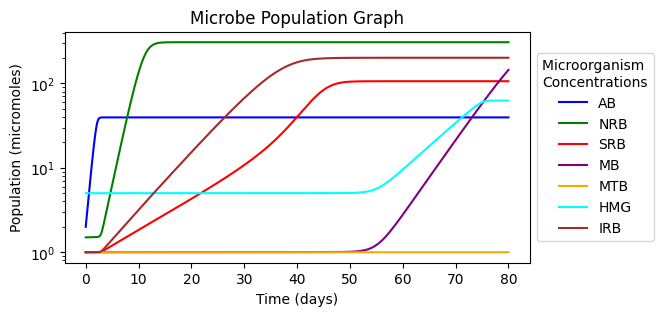

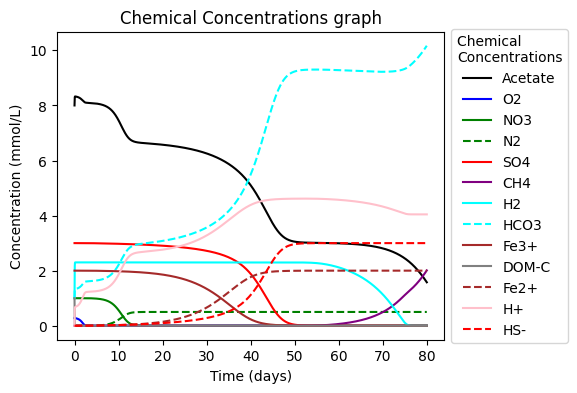

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 0.25 * 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
kironi = 1e-3  # Inhibition constant for iron in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 0.1 * 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Initial values
# Aerobic
acetate0 = 8e-3  # mol/L
o20 = .28e-3  # mol/L
AB0 = 2.0E-6  # mol-bio/L  # aAB

# Denitrifying
no30 = 1.0e-3  # mol/L
n20 = 0.0  # mol/L
NRB0 = 1.5e-6  # mol-bio/L

# Sulfate
so40 = 3.0e-3  # mol/L
SRB0 = 1e-6  # mol-bio/L
HS0 = 0.0  # mol/L (initial HS- concentration)

# Methanogenesis and Methanotrophy
MB0 = 1e-6  # mol-bio/L (methanogenic biomass)
CH40 = 0.0  # mol/L (methane)
MTB0 = 1e-6  # mol-bio/L (methanotrophic biomass)

# Hydrogenotrophic Methanogenesis
HMG0 = 10 * 5e-7  # mol-bio/L (hydrogenotrophic methanogenic biomass)
H20 = 1e-3  # mol/L (hydrogen)
HCO30 = 1e-3  # mol/L (bicarbonate)

# Iron reduction
fe3p0 = 2.0e-3  # mol/L (Fe3+)
IRB0 = 1.0e-6  # mol-bio/L (iron-reducing biomass)
fe2p0 = 0.0  # mol/L (Fe2+)

# DOM-C initial concentration
domc0 = 1e-3  # mol/L (dissolved organic carbon)

# H+ initial concentration
hplus0 = 0.0  # mol/L (H+)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus, hs = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0
    dHS = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = 1e-2 * muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) * (kironi / (kironi + fe3p))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction
    dHS += 0.125 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy =  muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus, dHS])

# Time parameters for integration
Nt = 100000
tmax = 80.0
t = np.linspace(0.0, tmax, Nt)

# Initial conditions
X0 = [acetate0, o20, AB0, no30, n20, NRB0, so40, SRB0, MB0, MTB0, HMG0, CH40, H20, HCO30, fe3p0, IRB0, domc0, fe2p0, hplus0, HS0]

# Integrate the ODE system
res = odeint(derivative, X0, t)

# Extract and convert concentrations
variables = res.T
microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
chemicals = [variables[0], variables[1], variables[3], variables[4], variables[6], variables[11], variables[12], variables[13], variables[14], variables[16], variables[17], variables[18], variables[19]]  # Chemical concentrations

# Define colors for each process
colors = {
    "Aerobic": "blue",
    "Denitrification": "green",
    "Sulfate Reduction": "red",
    "Methanogenesis": "purple",
    "Methanotrophy": "orange",
    "Hydrogenotrophic Methanogenesis": "cyan",
    "Iron Reduction": "brown"
}

# Plotting microbes
plt.figure(figsize=(6, 3))
microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
microbe_colors = ["blue", "green", "red", "purple", "orange", "cyan", "brown"]
for i, microbe in enumerate(microbes):
    plt.plot(t, microbe * 1e6, label=microbe_names[i], color=microbe_colors[i])  # Convert to micromoles
plt.yscale('log')
plt.title("Microbe Population Graph")
plt.xlabel("Time (days)")
plt.ylabel("Population (micromoles)")
plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting chemical concentrations
plt.figure(figsize=(5, 4))
chemical_names = ["Acetate", "O2", "NO3", "N2", "SO4", "CH4", "H2", "HCO3", "Fe3+", "DOM-C", "Fe2+", "H+", "HS-"]
chemical_colors = ["black", "blue", "green", "green", "red", "purple", "cyan", "cyan", "brown", "grey", "brown", "pink", "red"]
chemical_linestyles = ["solid", "solid", "solid", "dashed", "solid", "solid", "solid", "dashed", "solid", "solid", "dashed", "solid", "dashed"]

for i, chemical in enumerate(chemicals):
    plt.plot(t, chemical * 1e3, label=chemical_names[i], color=chemical_colors[i], linestyle=chemical_linestyles[i])  # Convert to mmol/L
plt.title("Chemical Concentrations graph")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


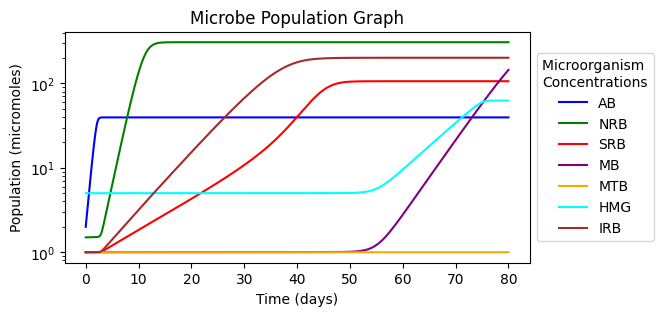

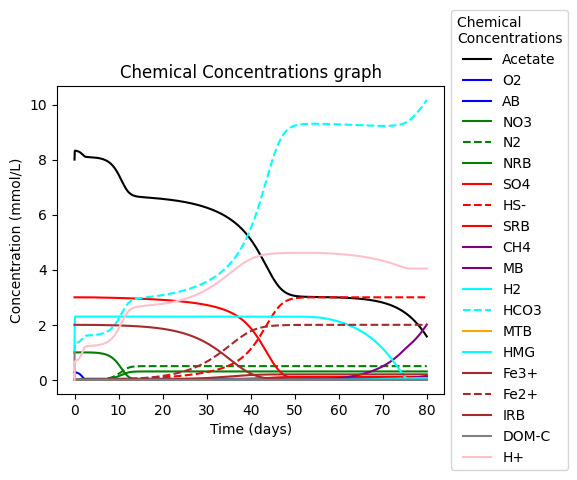

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 0.25 * 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
kironi = 1e-3  # Inhibition constant for iron in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 0.1 * 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Initial values
# Aerobic
acetate0 = 8e-3  # mol/L
o20 = .28e-3  # mol/L
AB0 = 2.0E-6  # mol-bio/L  # aAB

# Denitrifying
no30 = 1.0e-3  # mol/L
n20 = 0.0  # mol/L
NRB0 = 1.5e-6  # mol-bio/L

# Sulfate
so40 = 3.0e-3  # mol/L
SRB0 = 1e-6  # mol-bio/L
HS0 = 0.0  # mol/L (initial HS- concentration)

# Methanogenesis and Methanotrophy
MB0 = 1e-6  # mol-bio/L (methanogenic biomass)
CH40 = 0.0  # mol/L (methane)
MTB0 = 1e-6  # mol-bio/L (methanotrophic biomass)

# Hydrogenotrophic Methanogenesis
HMG0 = 10 * 5e-7  # mol-bio/L (hydrogenotrophic methanogenic biomass)
H20 = 1e-3  # mol/L (hydrogen)
HCO30 = 1e-3  # mol/L (bicarbonate)

# Iron reduction
fe3p0 = 2.0e-3  # mol/L (Fe3+)
IRB0 = 1.0e-6  # mol-bio/L (iron-reducing biomass)
fe2p0 = 0.0  # mol/L (Fe2+)

# DOM-C initial concentration
domc0 = 1e-3  # mol/L (dissolved organic carbon)

# H+ initial concentration
hplus0 = 0.0  # mol/L (H+)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus, hs = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0
    dHS = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = 1e-2 * muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) * (kironi / (kironi + fe3p))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction
    dHS += 0.125 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy =  muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus, dHS])

# Time parameters for integration
Nt = 100000
tmax = 80.0
t = np.linspace(0.0, tmax, Nt)

# Initial conditions
X0 = [acetate0, o20, AB0, no30, n20, NRB0, so40, SRB0, MB0, MTB0, HMG0, CH40, H20, HCO30, fe3p0, IRB0, domc0, fe2p0, hplus0, HS0]

# Integrate the ODE system
res = odeint(derivative, X0, t)

# Extract and convert concentrations
variables = res.T
microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
chemicals = [variables[0], variables[1], variables[3], variables[4], variables[6], variables[11], variables[12], variables[13], variables[14], variables[16], variables[17], variables[18], variables[19]]  # Chemical concentrations

# Define colors for each process
colors = {
    "Aerobic": "blue",
    "Denitrification": "green",
    "Sulfate Reduction": "red",
    "Methanogenesis": "purple",
    "Methanotrophy": "orange",
    "Hydrogenotrophic Methanogenesis": "cyan",
    "Iron Reduction": "brown"
}

# Plotting microbes
plt.figure(figsize=(6, 3))
microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
microbe_colors = ["blue", "green", "red", "purple", "orange", "cyan", "brown"]
for i, microbe in enumerate(microbes):
    plt.plot(t, microbe * 1e6, label=microbe_names[i], color=microbe_colors[i])  # Convert to micromoles
plt.yscale('log')
plt.title("Microbe Population Graph")
plt.xlabel("Time (days)")
plt.ylabel("Population (micromoles)")
plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting chemical concentrations
plt.figure(figsize=(5, 4))
chemical_names = ["Acetate", "O2", "NO3", "N2", "SO4", "CH4", "H2", "HCO3", "Fe3+", "DOM-C", "Fe2+", "H+", "HS-"]
chemical_colors = ["black", "blue", "green", "green", "red", "purple", "cyan", "cyan", "brown", "grey", "brown", "pink", "red"]
chemical_linestyles = ["solid", "solid", "solid", "dashed", "solid", "solid", "solid", "dashed", "solid", "solid", "dashed", "solid", "dashed"]

# Grouping the lines in order of color
ordered_chemicals = [
    (chemicals[0], "Acetate", "black", "solid"),
    (chemicals[1], "O2", "blue", "solid"),
    (microbes[0], "AB", "blue", "solid"),
    (chemicals[2], "NO3", "green", "solid"),
    (chemicals[3], "N2", "green", "dashed"),
    (microbes[1], "NRB", "green", "solid"),
    (chemicals[4], "SO4", "red", "solid"),
    (chemicals[12], "HS-", "red", "dashed"),
    (microbes[2], "SRB", "red", "solid"),
    (chemicals[5], "CH4", "purple", "solid"),
    (microbes[3], "MB", "purple", "solid"),
    (chemicals[6], "H2", "cyan", "solid"),
    (chemicals[7], "HCO3", "cyan", "dashed"),
    (microbes[4], "MTB", "orange", "solid"),
    (microbes[5], "HMG", "cyan", "solid"),
    (chemicals[8], "Fe3+", "brown", "solid"),
    (chemicals[10], "Fe2+", "brown", "dashed"),
    (microbes[6], "IRB", "brown", "solid"),
    (chemicals[9], "DOM-C", "grey", "solid"),
    (chemicals[11], "H+", "pink", "solid"),
]

for chemical, name, color, linestyle in ordered_chemicals:
    plt.plot(t, chemical * 1e3, label=name, color=color, linestyle=linestyle)  # Convert to mmol/L

plt.title("Chemical Concentrations graph")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


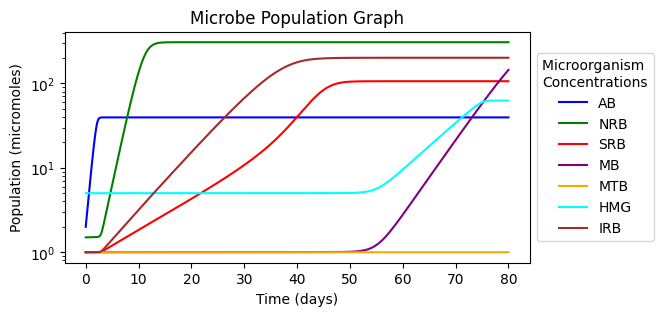

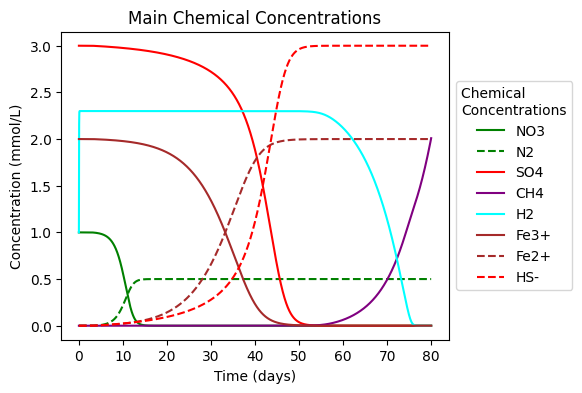

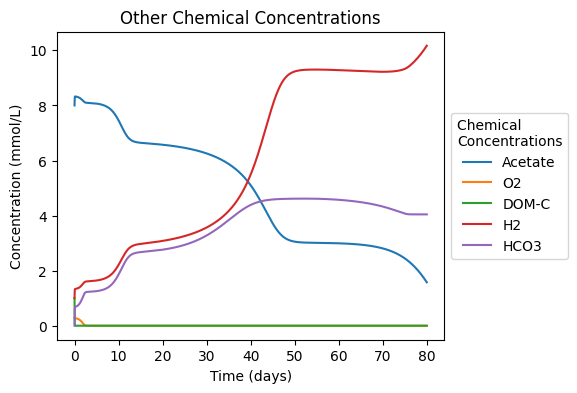

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 0.25 * 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
kironi = 1e-3  # Inhibition constant for iron in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 0.1 * 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Initial values
# Aerobic
acetate0 = 8e-3  # mol/L
o20 = .28e-3  # mol/L
AB0 = 2.0E-6  # mol-bio/L  # aAB

# Denitrifying
no30 = 1.0e-3  # mol/L
n20 = 0.0  # mol/L
NRB0 = 1.5e-6  # mol-bio/L

# Sulfate
so40 = 3.0e-3  # mol/L
SRB0 = 1e-6  # mol-bio/L
HS0 = 0.0  # mol/L (initial HS- concentration)

# Methanogenesis and Methanotrophy
MB0 = 1e-6  # mol-bio/L (methanogenic biomass)
CH40 = 0.0  # mol/L (methane)
MTB0 = 1e-6  # mol-bio/L (methanotrophic biomass)

# Hydrogenotrophic Methanogenesis
HMG0 = 10 * 5e-7  # mol-bio/L (hydrogenotrophic methanogenic biomass)
H20 = 1e-3  # mol/L (hydrogen)
HCO30 = 1e-3  # mol/L (bicarbonate)

# Iron reduction
fe3p0 = 2.0e-3  # mol/L (Fe3+)
IRB0 = 1.0e-6  # mol-bio/L (iron-reducing biomass)
fe2p0 = 0.0  # mol/L (Fe2+)

# DOM-C initial concentration
domc0 = 1e-3  # mol/L (dissolved organic carbon)

# H+ initial concentration
hplus0 = 0.0  # mol/L (H+)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus, hs = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0
    dHS = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = 1e-2 * muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) * (kironi / (kironi + fe3p))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction
    dHS += 0.125 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy =  muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus, dHS])

# Time parameters for integration
Nt = 100000
tmax = 80.0
t = np.linspace(0.0, tmax, Nt)

# Initial conditions
X0 = [acetate0, o20, AB0, no30, n20, NRB0, so40, SRB0, MB0, MTB0, HMG0, CH40, H20, HCO30, fe3p0, IRB0, domc0, fe2p0, hplus0, HS0]

# Integrate the ODE system
res = odeint(derivative, X0, t)

# Extract and convert concentrations
variables = res.T
microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
chemicals = [variables[3], variables[4], variables[6], variables[11], variables[12], variables[14], variables[17], variables[19]]  # Main chemical concentrations
other_chemicals = [variables[0], variables[1], variables[16], variables[13], variables[18]]  # Acetate, O2, DOM-C, HCO3, H+

# Define colors for each process
colors = {
    "Aerobic": "blue",
    "Denitrification": "green",
    "Sulfate Reduction": "red",
    "Methanogenesis": "purple",
    "Methanotrophy": "orange",
    "Hydrogenotrophic Methanogenesis": "cyan",
    "Iron Reduction": "brown"
}

# Plotting microbes
plt.figure(figsize=(6, 3))
microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
microbe_colors = ["blue", "green", "red", "purple", "orange", "cyan", "brown"]
for i, microbe in enumerate(microbes):
    plt.plot(t, microbe * 1e6, label=microbe_names[i], color=microbe_colors[i])  # Convert to micromoles
plt.yscale('log')
plt.title("Microbe Population Graph")
plt.xlabel("Time (days)")
plt.ylabel("Population (micromoles)")
plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting main chemical concentrations
plt.figure(figsize=(5, 4))
chemical_names = ["NO3", "N2", "SO4", "CH4", "H2", "Fe3+", "Fe2+", "HS-"]
chemical_colors = ["green", "green", "red", "purple", "cyan", "brown", "brown", "red"]
chemical_linestyles = ["solid", "dashed", "solid", "solid", "solid", "solid", "dashed", "dashed"]

for i, chemical in enumerate(chemicals):
    plt.plot(t, chemical * 1e3, label=chemical_names[i], color=chemical_colors[i], linestyle=chemical_linestyles[i])  # Convert to mmol/L
plt.title("Main Chemical Concentrations")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting other chemical concentrations
plt.figure(figsize=(5, 4))
other_chemical_names = ["Acetate", "O2", "DOM-C", "H2" "HCO3", "H+"]
other_chemical_colors = ["black", "blue", "grey", "cyan", "pink"]
other_chemical_linestyles = ["solid", "solid", "solid", "dashed", "solid"]

for i, chemical in enumerate(other_chemicals):
    plt.plot(t, chemical * 1e3, label=other_chemical_names[i], color=other_chemical_colors[i], linestyle=other_chemical_linestyles[i])  # Convert to mmol/L
plt.title("Other Chemical Concentrations")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


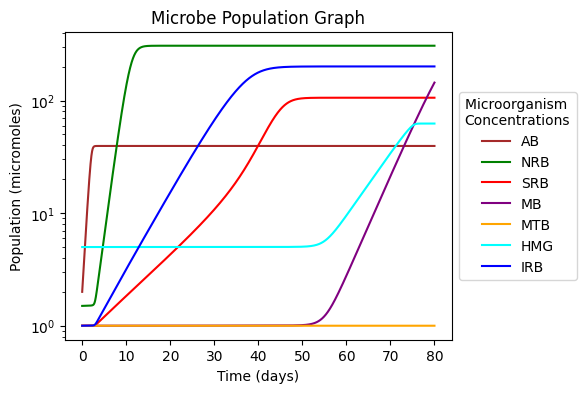

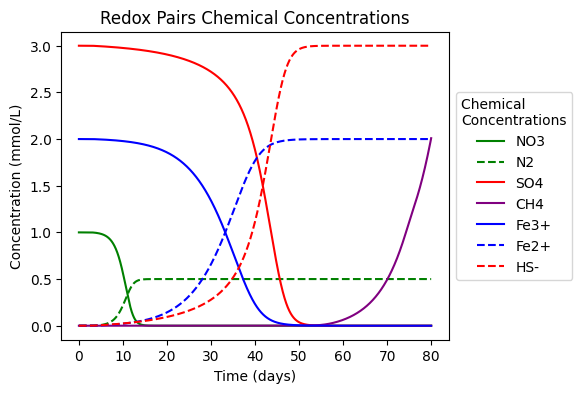

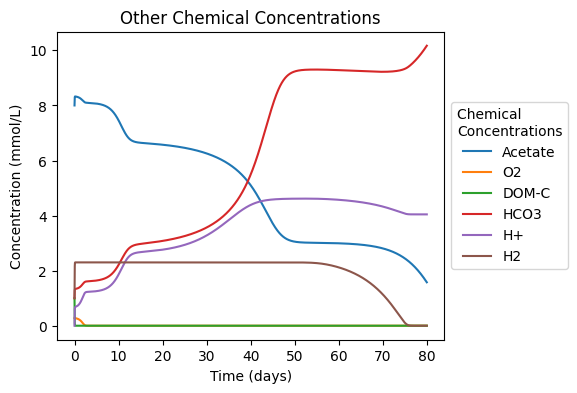

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 0.25 * 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
kironi = 1e-3  # Inhibition constant for iron in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 0.1 * 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Initial values
# Aerobic
acetate0 = 8e-3  # mol/L
o20 = .28e-3  # mol/L
AB0 = 2.0E-6  # mol-bio/L  # aAB

# Denitrifying
no30 = 1.0e-3  # mol/L
n20 = 0.0  # mol/L
NRB0 = 1.5e-6  # mol-bio/L

# Sulfate
so40 = 3.0e-3  # mol/L
SRB0 = 1e-6  # mol-bio/L
HS0 = 0.0  # mol/L (initial HS- concentration)

# Methanogenesis and Methanotrophy
MB0 = 1e-6  # mol-bio/L (methanogenic biomass)
CH40 = 0.0  # mol/L (methane)
MTB0 = 1e-6  # mol-bio/L (methanotrophic biomass)

# Hydrogenotrophic Methanogenesis
HMG0 = 10 * 5e-7  # mol-bio/L (hydrogenotrophic methanogenic biomass)
H20 = 1e-3  # mol/L (hydrogen)
HCO30 = 1e-3  # mol/L (bicarbonate)

# Iron reduction
fe3p0 = 2.0e-3  # mol/L (Fe3+)
IRB0 = 1.0e-6  # mol-bio/L (iron-reducing biomass)
fe2p0 = 0.0  # mol/L (Fe2+)

# DOM-C initial concentration
domc0 = 1e-3  # mol/L (dissolved organic carbon)

# H+ initial concentration
hplus0 = 0.0  # mol/L (H+)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus, hs = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0
    dHS = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = 1e-2 * muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) * (kironi / (kironi + fe3p))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction
    dHS += 0.125 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy =  muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus, dHS])

# Time parameters for integration
Nt = 100000
tmax = 80.0
t = np.linspace(0.0, tmax, Nt)

# Initial conditions
X0 = [acetate0, o20, AB0, no30, n20, NRB0, so40, SRB0, MB0, MTB0, HMG0, CH40, H20, HCO30, fe3p0, IRB0, domc0, fe2p0, hplus0, HS0]

# Integrate the ODE system
res = odeint(derivative, X0, t)

# Extract and convert concentrations
variables = res.T
microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
chemicals = [variables[3], variables[4], variables[6], variables[11], variables[14], variables[17], variables[19]]  # Main chemical concentrations
other_chemicals = [variables[0], variables[1], variables[16], variables[13], variables[18], variables[12]]  # Acetate, O2, DOM-C, HCO3, H+, H2


# Plotting microbes
plt.figure(figsize=(5, 4))
microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
microbe_colors = ["brown", "green", "red", "purple", "orange", "cyan", "blue"]
for i, microbe in enumerate(microbes):
    plt.plot(t, microbe * 1e6, label=microbe_names[i], color=microbe_colors[i])  # Convert to micromoles
plt.yscale('log')
plt.title("Microbe Population Graph")
plt.xlabel("Time (days)")
plt.ylabel("Population (micromoles)")
plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting main chemical concentrations
plt.figure(figsize=(5, 4))
chemical_names = ["NO3", "N2", "SO4", "CH4", "Fe3+", "Fe2+", "HS-"]
chemical_colors = ["green", "green", "red", "purple", "blue", "blue", "red"]
chemical_linestyles = ["solid", "dashed", "solid", "solid", "solid", "dashed", "dashed"]

for i, chemical in enumerate(chemicals):
    plt.plot(t, chemical * 1e3, label=chemical_names[i], color=chemical_colors[i], linestyle=chemical_linestyles[i])  # Convert to mmol/L
plt.title("Redox Pairs Chemical Concentrations")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting other chemical concentrations
plt.figure(figsize=(5, 4))
other_chemical_names = ["Acetate", "O2", "DOM-C", "HCO3", "H+", "H2"]
other_chemical_colors = ["black", "blue", "grey", "cyan", "pink", "cyan"]
other_chemical_linestyles = ["solid", "solid", "solid", "dashed", "solid", "solid"]

for i, chemical in enumerate(other_chemicals):
    plt.plot(t, chemical * 1e3, label=other_chemical_names[i])  # Convert to mmol/L
plt.title("Other Chemical Concentrations")
plt.xlabel("Time (days)")
plt.ylabel("Concentration (mmol/L)")
plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


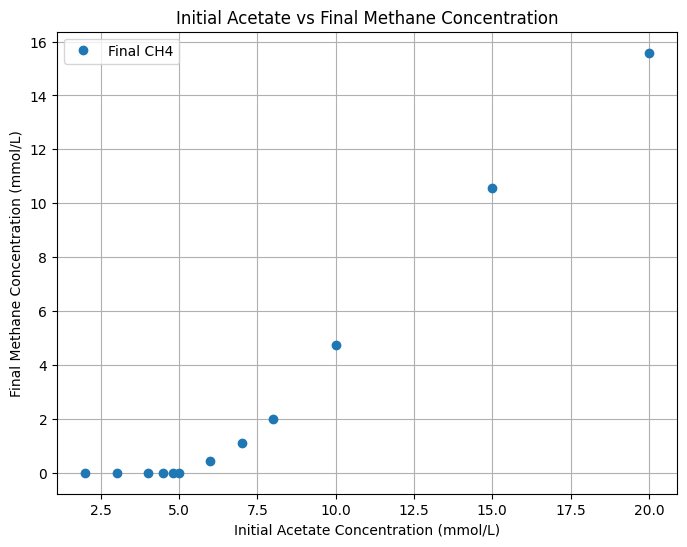

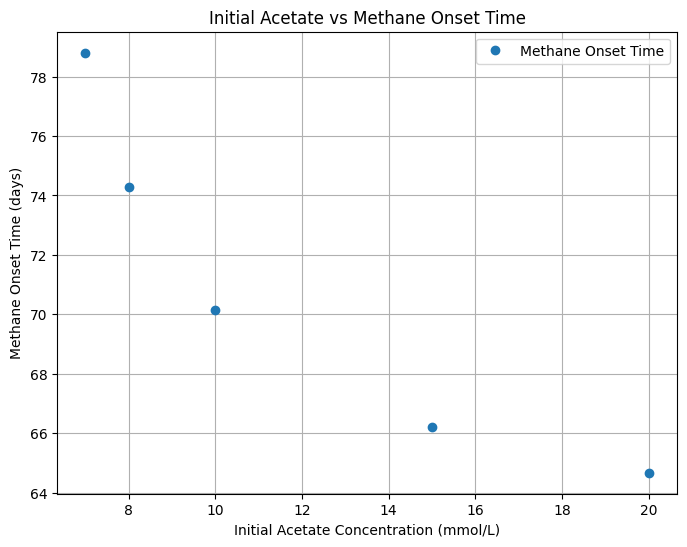

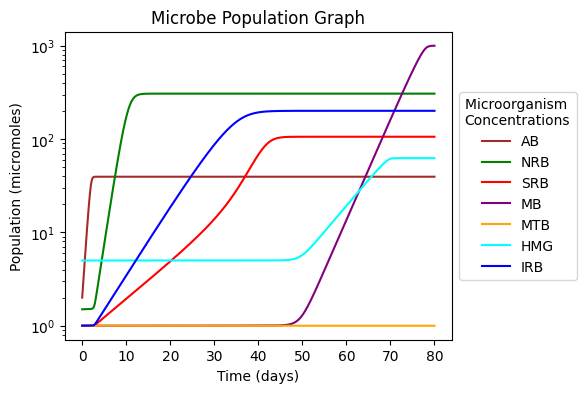

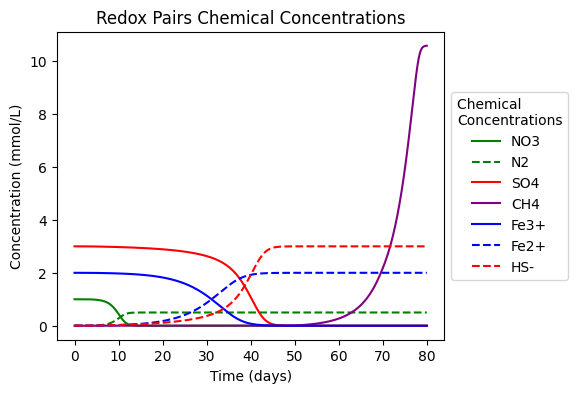

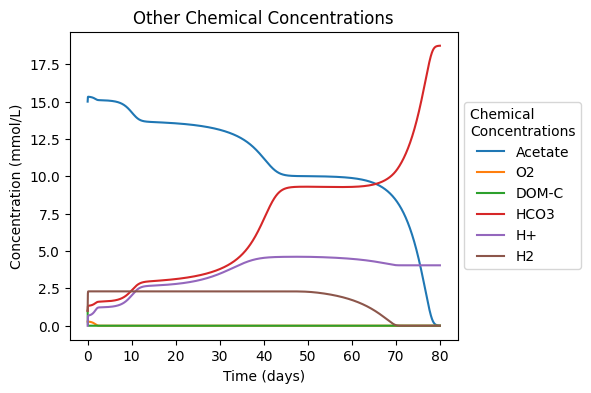

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 0.25 * 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
kironi = 1e-3  # Inhibition constant for iron in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 0.1 * 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 0.1 * 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Initial values
# Aerobic
acetate0 = 8e-3  # mol/L
o20 = .28e-3  # mol/L
AB0 = 2.0E-6  # mol-bio/L  # aAB

# Denitrifying
no30 = 1.0e-3  # mol/L
n20 = 0.0  # mol/L
NRB0 = 1.5e-6  # mol-bio/L

# Sulfate
so40 = 3.0e-3  # mol/L
SRB0 = 1e-6  # mol-bio/L
HS0 = 0.0  # mol/L (initial HS- concentration)

# Methanogenesis and Methanotrophy
MB0 = 1e-6  # mol-bio/L (methanogenic biomass)
CH40 = 0.0  # mol/L (methane)
MTB0 = 1e-6  # mol-bio/L (methanotrophic biomass)

# Hydrogenotrophic Methanogenesis
HMG0 = 10 * 5e-7  # mol-bio/L (hydrogenotrophic methanogenic biomass)
H20 = 1e-3  # mol/L (hydrogen)
HCO30 = 1e-3  # mol/L (bicarbonate)

# Iron reduction
fe3p0 = 2.0e-3  # mol/L (Fe3+)
IRB0 = 1.0e-6  # mol-bio/L (iron-reducing biomass)
fe2p0 = 0.0  # mol/L (Fe2+)

# DOM-C initial concentration
domc0 = 1e-3  # mol/L (dissolved organic carbon)

# H+ initial concentration
hplus0 = 0.0  # mol/L (H+)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus, hs = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0
    dHS = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = 1e-2 * muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) * (kironi / (kironi + fe3p))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction
    dHS += 0.125 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy = muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus, dHS])

# Function to run the model and return results
def run_model(initial_conditions, tmax=80.0, Nt=100000):
    t = np.linspace(0.0, tmax, Nt)
    res = odeint(derivative, initial_conditions, t)
    return t, res

# Function to convert initial conditions dictionary to list
def convert_initial_conditions_dict_to_list(initial_conditions_dict):
    return [
        initial_conditions_dict['acetate'],
        initial_conditions_dict['o2'],
        initial_conditions_dict['ab'],
        initial_conditions_dict['no3'],
        initial_conditions_dict['n2'],
        initial_conditions_dict['nrb'],
        initial_conditions_dict['so4'],
        initial_conditions_dict['srb'],
        initial_conditions_dict['mb'],
        initial_conditions_dict['mtb'],
        initial_conditions_dict['hmg'],
        initial_conditions_dict['ch4'],
        initial_conditions_dict['h2'],
        initial_conditions_dict['hco3'],
        initial_conditions_dict['fe3p'],
        initial_conditions_dict['irb'],
        initial_conditions_dict['domc'],
        initial_conditions_dict['fe2p'],
        initial_conditions_dict['hplus'],
        initial_conditions_dict['hs']
    ]

# Initial conditions for different scenarios
scenarios = [
    {
        'acetate': 8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 4e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 3e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 2e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 4.5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 4.8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 6e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 7e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 10e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 15e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 20e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
]

# Store the results
initial_acetate_concentrations = []
final_methane_concentrations = []

# Run model for each scenario and store the results

# Store the results
initial_acetate_concentrations = []
final_methane_concentrations = []
methane_onset_times = []

# Run model for each scenario and store the results
for i, scenario in enumerate(scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    t, res = run_model(initial_conditions_list)
    methane_concentration = res[:, 11] * 1e3  # Convert to mmol/L

    # Find the onset time for methane to reach above 1 mmol/L
    onset_time = next((t[j] for j in range(len(methane_concentration)) if methane_concentration[j] > 1.0), None)

    final_methane_concentrations.append(methane_concentration[-1])
    initial_acetate_concentrations.append(scenario['acetate'] * 1e3)  # Convert to mmol/L for plotting
    methane_onset_times.append(onset_time)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(initial_acetate_concentrations, final_methane_concentrations, 'o', label='Final CH4')
plt.xlabel("Initial Acetate Concentration (mmol/L)")
plt.ylabel("Final Methane Concentration (mmol/L)")
plt.title("Initial Acetate vs Final Methane Concentration")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(initial_acetate_concentrations, methane_onset_times, 'o', label='Methane Onset Time')
plt.xlabel("Initial Acetate Concentration (mmol/L)")
plt.ylabel("Methane Onset Time (days)")
plt.title("Initial Acetate vs Methane Onset Time")
plt.legend()
plt.grid(True)
plt.show()

# Function to plot results for a specific scenario
def plot_scenario_results(scenario_index):
    scenario = scenarios[scenario_index]
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    t, res = run_model(initial_conditions_list)

    # Extract and convert concentrations
    variables = res.T
    microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
    chemicals = [variables[3], variables[4], variables[6], variables[11], variables[14], variables[17], variables[19]]  # Main chemical concentrations
    other_chemicals = [variables[0], variables[1], variables[16], variables[13], variables[18], variables[12]]  # Acetate, O2, DOM-C, HCO3, H+, H2

    # Plotting microbes
    plt.figure(figsize=(5, 4))
    microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
    microbe_colors = ["brown", "green", "red", "purple", "orange", "cyan", "blue"]
    for i, microbe in enumerate(microbes):
        plt.plot(t, microbe * 1e6, label=microbe_names[i], color=microbe_colors[i])  # Convert to micromoles
    plt.yscale('log')
    plt.title("Microbe Population Graph")
    plt.xlabel("Time (days)")
    plt.ylabel("Population (micromoles)")
    plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # Plotting main chemical concentrations
    plt.figure(figsize=(5, 4))
    chemical_names = ["NO3", "N2", "SO4", "CH4", "Fe3+", "Fe2+", "HS-"]
    chemical_colors = ["green", "green", "red", "purple", "blue", "blue", "red"]
    chemical_linestyles = ["solid", "dashed", "solid", "solid", "solid", "dashed", "dashed"]

    for i, chemical in enumerate(chemicals):
        plt.plot(t, chemical * 1e3, label=chemical_names[i], color=chemical_colors[i], linestyle=chemical_linestyles[i])  # Convert to mmol/L
    plt.title("Redox Pairs Chemical Concentrations")
    plt.xlabel("Time (days)")
    plt.ylabel("Concentration (mmol/L)")
    plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # Plotting other chemical concentrations
    plt.figure(figsize=(5, 4))
    other_chemical_names = ["Acetate", "O2", "DOM-C", "HCO3", "H+", "H2"]
    other_chemical_colors = ["black", "blue", "grey", "cyan", "pink", "cyan"]
    other_chemical_linestyles = ["solid", "solid", "solid", "dashed", "solid", "solid"]

    for i, chemical in enumerate(other_chemicals):
        plt.plot(t, chemical * 1e3, label=other_chemical_names[i])  # Convert to mmol/L
    plt.title("Other Chemical Concentrations")
    plt.xlabel("Time (days)")
    plt.ylabel("Concentration (mmol/L)")
    plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Choose which scenario to graph (change the index to the desired scenario)
plot_scenario_results(10)  # Example: plot the results for the first scenario


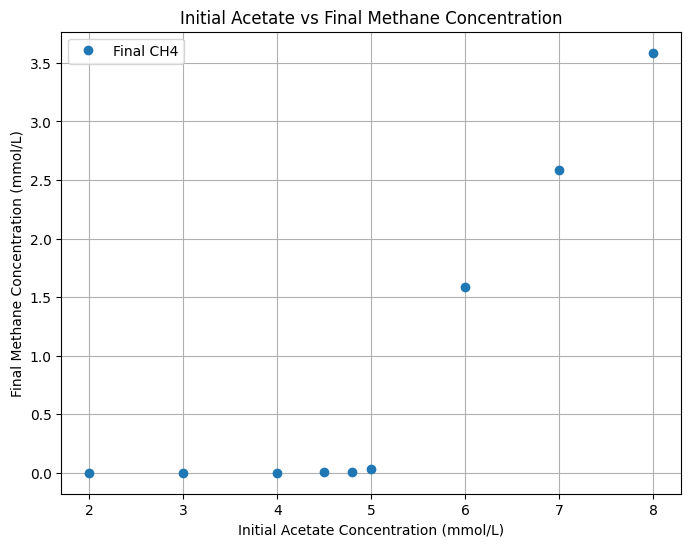

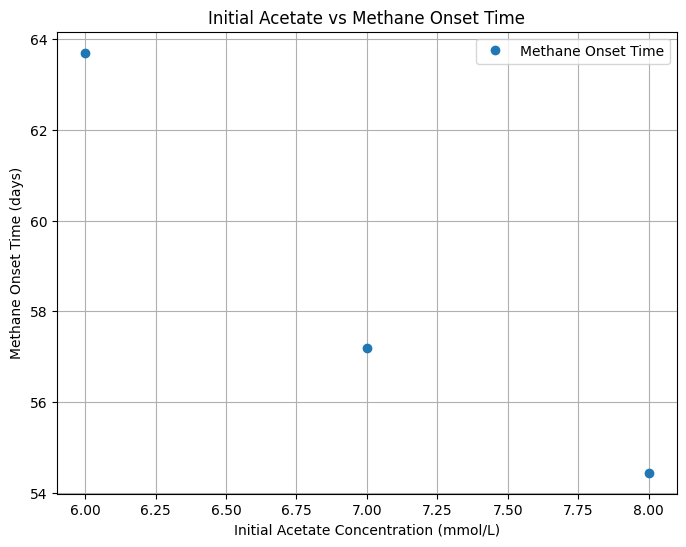

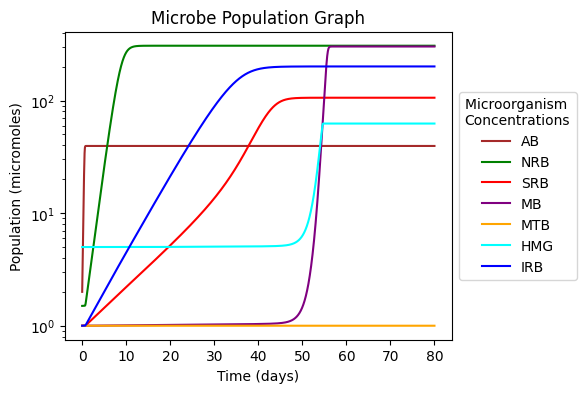

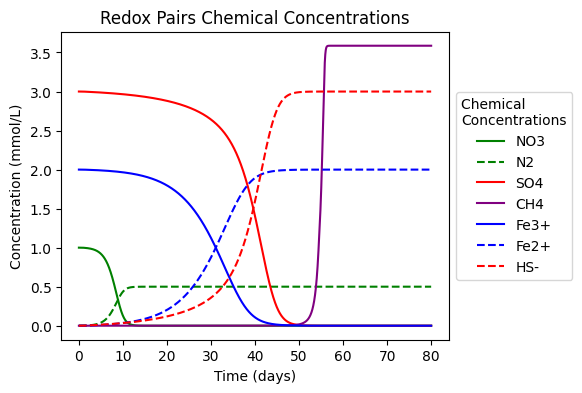

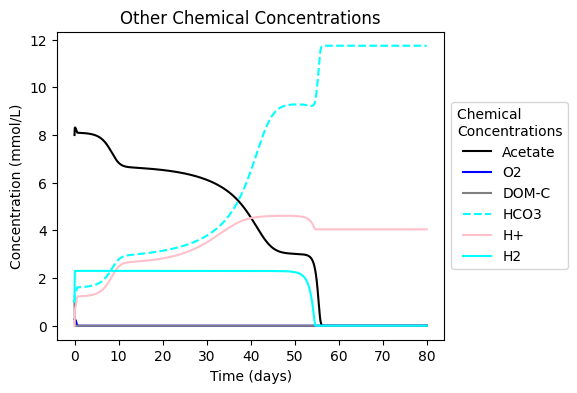

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
kironi = 1e-3  # Inhibition constant for iron in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 5000.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus, hs = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0
    dHS = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = 1e-2 * muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) * (kironi / (kironi + fe3p))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction
    dHS += 0.125 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy = muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus, dHS])

# Function to run the model and return results
def run_model(initial_conditions, tmax=80.0, Nt=100000):
    t = np.linspace(0.0, tmax, Nt)
    res = odeint(derivative, initial_conditions, t)
    return t, res

# Function to convert initial conditions dictionary to list
def convert_initial_conditions_dict_to_list(initial_conditions_dict):
    return [
        initial_conditions_dict['acetate'],
        initial_conditions_dict['o2'],
        initial_conditions_dict['ab'],
        initial_conditions_dict['no3'],
        initial_conditions_dict['n2'],
        initial_conditions_dict['nrb'],
        initial_conditions_dict['so4'],
        initial_conditions_dict['srb'],
        initial_conditions_dict['mb'],
        initial_conditions_dict['mtb'],
        initial_conditions_dict['hmg'],
        initial_conditions_dict['ch4'],
        initial_conditions_dict['h2'],
        initial_conditions_dict['hco3'],
        initial_conditions_dict['fe3p'],
        initial_conditions_dict['irb'],
        initial_conditions_dict['domc'],
        initial_conditions_dict['fe2p'],
        initial_conditions_dict['hplus'],
        initial_conditions_dict['hs']
    ]

# Initial conditions for different scenarios
scenarios = [
    {
        'acetate': 8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 4e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 3e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 2e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 4.5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 4.8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 6e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 7e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
]

# Store the results
initial_acetate_concentrations = []
final_methane_concentrations = []
methane_onset_times = []

# Run model for each scenario and store the results
for i, scenario in enumerate(scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    t, res = run_model(initial_conditions_list)
    methane_concentration = res[:, 11] * 1e3  # Convert to mmol/L

    # Find the onset time for methane to reach above 1 mmol/L
    onset_time = next((t[j] for j in range(len(methane_concentration)) if methane_concentration[j] > 1.0), None)

    final_methane_concentrations.append(methane_concentration[-1])
    initial_acetate_concentrations.append(scenario['acetate'] * 1e3)  # Convert to mmol/L for plotting
    methane_onset_times.append(onset_time)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(initial_acetate_concentrations, final_methane_concentrations, 'o', label='Final CH4')
plt.xlabel("Initial Acetate Concentration (mmol/L)")
plt.ylabel("Final Methane Concentration (mmol/L)")
plt.title("Initial Acetate vs Final Methane Concentration")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(initial_acetate_concentrations, methane_onset_times, 'o', label='Methane Onset Time')
plt.xlabel("Initial Acetate Concentration (mmol/L)")
plt.ylabel("Methane Onset Time (days)")
plt.title("Initial Acetate vs Methane Onset Time")
plt.legend()
plt.grid(True)
plt.show()

# Function to plot results for a specific scenario
def plot_scenario_results(scenario_index):
    scenario = scenarios[scenario_index]
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    t, res = run_model(initial_conditions_list)

    # Extract and convert concentrations
    variables = res.T
    microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
    chemicals = [variables[3], variables[4], variables[6], variables[11], variables[14], variables[17], variables[19]]  # Main chemical concentrations
    other_chemicals = [variables[0], variables[1], variables[16], variables[13], variables[18], variables[12]]  # Acetate, O2, DOM-C, HCO3, H+, H2

    # Plotting microbes
    plt.figure(figsize=(5, 4))
    microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
    microbe_colors = ["brown", "green", "red", "purple", "orange", "cyan", "blue"]
    for i, microbe in enumerate(microbes):
        plt.plot(t, microbe * 1e6, label=microbe_names[i], color=microbe_colors[i])  # Convert to micromoles
    plt.yscale('log')
    plt.title("Microbe Population Graph")
    plt.xlabel("Time (days)")
    plt.ylabel("Population (micromoles)")
    plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # Plotting main chemical concentrations
    plt.figure(figsize=(5, 4))
    chemical_names = ["NO3", "N2", "SO4", "CH4", "Fe3+", "Fe2+", "HS-"]
    chemical_colors = ["green", "green", "red", "purple", "blue", "blue", "red"]
    chemical_linestyles = ["solid", "dashed", "solid", "solid", "solid", "dashed", "dashed"]

    for i, chemical in enumerate(chemicals):
        plt.plot(t, chemical * 1e3, label=chemical_names[i], color=chemical_colors[i], linestyle=chemical_linestyles[i])  # Convert to mmol/L
    plt.title("Redox Pairs Chemical Concentrations")
    plt.xlabel("Time (days)")
    plt.ylabel("Concentration (mmol/L)")
    plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # Plotting other chemical concentrations
    plt.figure(figsize=(5, 4))
    other_chemical_names = ["Acetate", "O2", "DOM-C", "HCO3", "H+", "H2"]
    other_chemical_colors = ["black", "blue", "grey", "cyan", "pink", "cyan"]
    other_chemical_linestyles = ["solid", "solid", "solid", "dashed", "solid", "solid"]

    for i, chemical in enumerate(other_chemicals):
        plt.plot(t, chemical * 1e3, label=other_chemical_names[i], color=other_chemical_colors[i], linestyle=other_chemical_linestyles[i])  # Convert to mmol/L
    plt.title("Other Chemical Concentrations")
    plt.xlabel("Time (days)")
    plt.ylabel("Concentration (mmol/L)")
    plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Choose which scenario to graph (change the index to the desired scenario)
plot_scenario_results(0)  # Example: plot the results for the first scenario


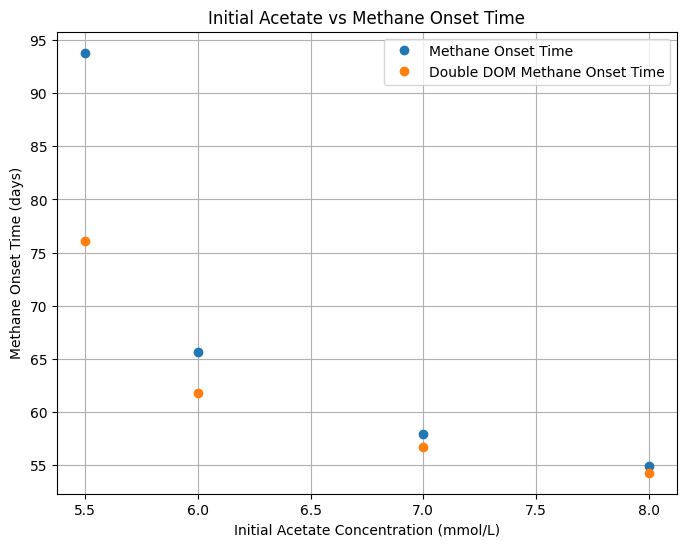

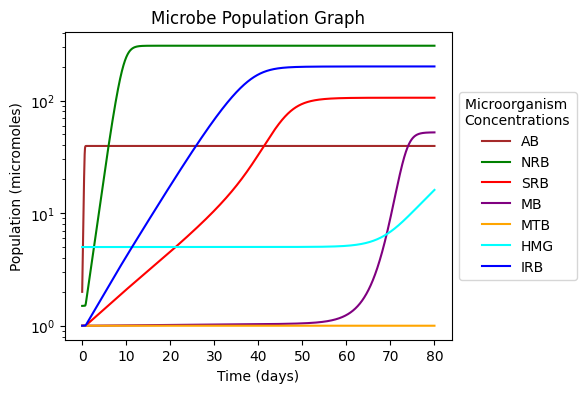

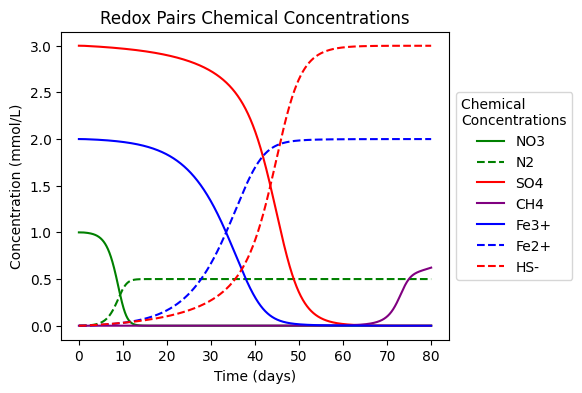

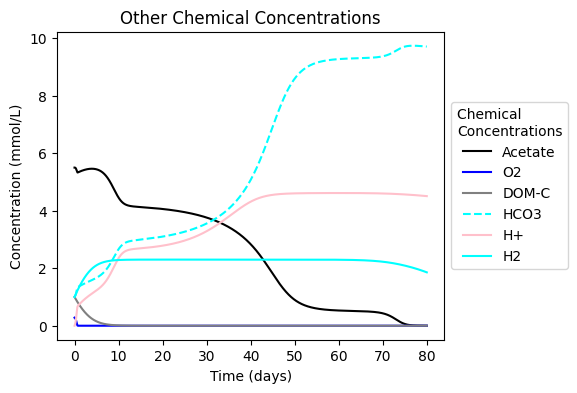

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants for the system

# Aerobic parameters
koa = 1e-4  # Michaelis-Menten constant for the acceptor in aerobic processes (mol/L)
kod = 1e-3  # Michaelis-Menten constant for the electron donor in aerobic processes (mol/L)
muMaxO = 50000.0 / 365.0  # Maximum specific growth rate in aerobic processes (mol/mol-bio/day)

# Denitrification parameters
kna = 1.0e-3  # Michaelis-Menten constant for the acceptor in denitrification (mol/L)
knd = 1.0e-3  # Michaelis-Menten constant for the electron donor in denitrification (mol/L)
kni = 1.0e-6  # Inhibition constant for O2 in denitrification (mol/L)
muMaxDN = 20000.0 / 365.0  # Maximum specific growth rate in denitrification (mol/mol-bio/day)

# Sulfate reduction parameters
ksa = 1.25e-3  # Michaelis-Menten constant for sulfate (mol/L)
ksd = 1.25e-3  # Michaelis-Menten constant for the electron donor in sulfate reduction (mol/L)
ks02i = 1e-6  # Inhibition constant for oxygen in sulfate reduction (mol/L)
ksno3i = 1e-3  # Inhibition constant for nitrate in sulfate reduction (mol/L)
kironi = 1e-3  # Inhibition constant for iron in sulfate reduction (mol/L)
muMaxSR = 35000.0 / 365.0  # Maximum specific growth rate in sulfate reduction (mol/mol-bio/day)

# Methanogenesis parameters
kma = 1e-3  # Michaelis-Menten constant for methanogenic substrate, e.g., acetate (mol/L)
kmi = 1e-6  # Inhibition constant for methanogenesis, e.g., by sulfate (mol/L)
muMaxMg = 10000.0 / 365.0  # Maximum specific growth rate of methanogens (mol/mol-bio/day)

# Methanotrophy parameters
kmtCH4 = 1e-3  # Michaelis-Menten constant for methane consumption by methanotrophs (mol/L)
muMaxMT = 5000.0 / 365.0  # Maximum specific growth rate of methanotrophs (mol/mol-bio/day)

# Hydrogenotrophic methanogenesis parameters
kH2 = 1e-4  # Michaelis-Menten constant for hydrogen (mol/L)
kHCO3 = 1e-4  # Michaelis-Menten constant for bicarbonate (mol/L)
muMaxHMG = 500.0 / 365.0  # Maximum specific growth rate of hydrogenotrophic methanogens (mol/mol-bio/day)
kmhi = 1e-6  # Additional inhibition constant

# Iron reduction parameters
kiron = 1.0e-3  # Michaelis-Menten constant for iron (mol/L)
kirond = 1.0e-3  # Michaelis-Menten constant for the electron donor in iron reduction (mol/L)
muMaxIR = 2000.0 / 365.0  # Maximum specific growth rate in iron reduction (mol/mol-bio/day)

# DOM-C degradation parameters
kdom = 1e-3  # Michaelis-Menten constant for DOM-C (mol/L)
muMaxDOM = 2000.0 / 365.0  # Maximum specific growth rate for DOM-C degradation (mol/mol-bio/day)

# Derivative function
def derivative(X, t):
    acetate, o2, ab, no3, n2, nrb, so4, srb, mb, mtb, hmg, ch4, h2, hco3, fe3p, irb, domc, fe2p, hplus, hs = X

    dAcetate = 0
    dO2 = 0
    dAb = 0
    dNo3 = 0
    dN2 = 0
    dNrb = 0
    dSo4 = 0
    dSrb = 0
    dMB = 0
    dMTB = 0
    dHMG = 0
    dCH4 = 0
    dH2 = 0
    dhco3 = 0
    dFe3p = 0
    dIrb = 0
    dDOMC = 0
    dFe2p = 0
    dhplus = 0
    dHS = 0

    # DOM-C degradation (Monod kinetics)
    dom_degradation = 1e-2 * muMaxDOM * domc / (kdom + domc)
    dDOMC -= dom_degradation
    dAcetate += 0.33 * dom_degradation
    dhco3 += 0.33 * dom_degradation
    dH2 += 1.3 * dom_degradation
    dhplus += 0.67 * dom_degradation

    # Aerobic processes
    daerobic = muMaxO * ab * (acetate / (kod + acetate)) * (o2 / (koa + o2))
    dAcetate -= 0.417 * daerobic
    dO2 -= 0.5 * daerobic
    dAb += 0.067 * daerobic
    dhco3 += 0.5 * daerobic
    dhplus += daerobic

    # Denitrifying processes
    ddenitrification = muMaxDN * nrb * (no3 / (kna + no3)) * (acetate / (knd + acetate)) * (kni / (kni + o2))
    dNo3 -= 0.090 * ddenitrification
    dAcetate -= 0.125 * ddenitrification
    dN2 += 0.045 * ddenitrification
    dNrb += 0.0275 * ddenitrification
    dhco3 += 0.1125 * ddenitrification
    dhplus += .125 * ddenitrification

    # Sulfate reduction process
    dsulfate_reduction = muMaxSR * srb * (so4 / (ksa + so4)) * (acetate / (ksd + acetate)) * (ks02i / (ks02i + o2)) * (kironi / (kironi + fe3p))
    dSo4 -= 0.125 * dsulfate_reduction
    dAcetate -= 0.13525 * dsulfate_reduction
    dSrb += 0.004375 * dsulfate_reduction
    dhco3 += 0.25 * dsulfate_reduction
    dHS += 0.125 * dsulfate_reduction

    # Iron reduction process
    diron_reduction = muMaxIR * irb * (fe3p / (kiron + fe3p)) * (acetate / (kirond + acetate)) * (ks02i / (ks02i + o2))
    dFe3p -= 0.5 * diron_reduction
    dFe2p += 0.5 * diron_reduction
    dAcetate -= 0.1125 * diron_reduction
    dIrb += 0.05 * diron_reduction
    dhco3 += 0.1125 * diron_reduction
    dhplus += 0.5 * diron_reduction

    # Acetoclastic Methanogenesis process
    dmethanogenesis = muMaxMg * mb * (acetate / (kma + acetate)) * (kmi / (kmi + so4)) * (ks02i / (ks02i + o2))
    dCH4 += dmethanogenesis
    dMB += 0.1 * dmethanogenesis
    dAcetate -= 1.0 * dmethanogenesis
    dhco3 += 1.0 * dmethanogenesis

    # Methanotrophy process
    dmethanotrophy = muMaxMT * mtb * (ch4 / (kmtCH4 + ch4)) * (o2 / (koa + o2))
    dMTB += 0.1 * dmethanotrophy
    dCH4 -= dmethanotrophy

    # Hydrogenotrophic methanogenesis process
    dhydrogenotrophic = muMaxHMG * hmg * (h2 / (kH2 + h2)) * (hco3 / (kHCO3 + hco3)) * (kmi / (kmi + so4)) * (kmhi / (kmhi + no3))
    dH2 -= 4.0 * dhydrogenotrophic
    dhco3 -= 1.0 * dhydrogenotrophic
    dhplus -= dhydrogenotrophic
    dHMG += 0.1 * dhydrogenotrophic
    dCH4 += dhydrogenotrophic

    return np.array([dAcetate, dO2, dAb, dNo3, dN2, dNrb, dSo4, dSrb, dMB, dMTB, dHMG, dCH4, dH2, dhco3, dFe3p, dIrb, dDOMC, dFe2p, dhplus, dHS])

# Function to run the model and return results
def run_model(initial_conditions, tmax=80.0, Nt=100000):
    t = np.linspace(0.0, tmax, Nt)
    res = odeint(derivative, initial_conditions, t)
    return t, res

# Function to convert initial conditions dictionary to list
def convert_initial_conditions_dict_to_list(initial_conditions_dict):
    return [
        initial_conditions_dict['acetate'],
        initial_conditions_dict['o2'],
        initial_conditions_dict['ab'],
        initial_conditions_dict['no3'],
        initial_conditions_dict['n2'],
        initial_conditions_dict['nrb'],
        initial_conditions_dict['so4'],
        initial_conditions_dict['srb'],
        initial_conditions_dict['mb'],
        initial_conditions_dict['mtb'],
        initial_conditions_dict['hmg'],
        initial_conditions_dict['ch4'],
        initial_conditions_dict['h2'],
        initial_conditions_dict['hco3'],
        initial_conditions_dict['fe3p'],
        initial_conditions_dict['irb'],
        initial_conditions_dict['domc'],
        initial_conditions_dict['fe2p'],
        initial_conditions_dict['hplus'],
        initial_conditions_dict['hs']
    ]

# Function to run the model and find methane onset time
def run_model_with_onset_time(initial_conditions, tmax=100.0, Nt=100000):
    t = np.linspace(0.0, tmax, Nt)
    res = odeint(derivative, initial_conditions, t)
    methane_concentration = res[:, 11] * 1e3  # Convert to mmol/L

    # Find the onset time for methane to reach above 1 mmol/L
    onset_time = next((t[j] for j in range(len(methane_concentration)) if methane_concentration[j] > 1.0), None)

    return onset_time, res

# Initial conditions for different scenarios
scenarios = [
    {
        'acetate': 8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 5.5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 4e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 3e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 2e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 4.5e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 4.8e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 6e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
    {
        'acetate': 7e-3,
        'o2': .28e-3,
        'ab': 2.0E-6,
        'no3': 1.0e-3,
        'n2': 0.0,
        'nrb': 1.5e-6,
        'so4': 3.0e-3,
        'srb': 1e-6,
        'mb': 1e-6,
        'mtb': 1e-6,
        'hmg': 10 * 5e-7,
        'ch4': 0.0,
        'h2': 1e-3,
        'hco3': 1e-3,
        'fe3p': 2.0e-3,
        'irb': 1.0e-6,
        'domc': 1e-3,
        'fe2p': 0.0,
        'hplus': 0.0,
        'hs': 0.0
    },
]

# Double DOM scenarios
double_dom_scenarios = [
    {**scenario, 'domc': scenario['domc'] * 2} for scenario in scenarios
]

# Store the results
initial_acetate_concentrations = []
final_methane_concentrations = []
methane_onset_times = []
double_dom_methane_onset_times = []

# Run model for each scenario and store the results
for i, scenario in enumerate(scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    onset_time, _ = run_model_with_onset_time(initial_conditions_list)
    initial_acetate_concentrations.append(scenario['acetate'] * 1e3)  # Convert to mmol/L for plotting
    methane_onset_times.append(onset_time)

# Run model for each double DOM scenario and store the results
for i, scenario in enumerate(double_dom_scenarios):
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    onset_time, _ = run_model_with_onset_time(initial_conditions_list)
    double_dom_methane_onset_times.append(onset_time)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(initial_acetate_concentrations, methane_onset_times, 'o', label='Methane Onset Time')
plt.plot(initial_acetate_concentrations, double_dom_methane_onset_times, 'o', label='Double DOM Methane Onset Time')
plt.xlabel("Initial Acetate Concentration (mmol/L)")
plt.ylabel("Methane Onset Time (days)")
plt.title("Initial Acetate vs Methane Onset Time")
plt.legend()
plt.grid(True)
plt.show()

# Function to plot results for a specific scenario
def plot_scenario_results(scenario_index):
    scenario = scenarios[scenario_index]
    initial_conditions_list = convert_initial_conditions_dict_to_list(scenario)
    t, res = run_model(initial_conditions_list)

    # Extract and convert concentrations
    variables = res.T
    microbes = [variables[2], variables[5], variables[7], variables[8], variables[9], variables[10], variables[15]]  # Microbial populations
    chemicals = [variables[3], variables[4], variables[6], variables[11], variables[14], variables[17], variables[19]]  # Main chemical concentrations
    other_chemicals = [variables[0], variables[1], variables[16], variables[13], variables[18], variables[12]]  # Acetate, O2, DOM-C, HCO3, H+, H2

    # Plotting microbes
    plt.figure(figsize=(5, 4))
    microbe_names = ["AB", "NRB", "SRB", "MB", "MTB", "HMG", "IRB"]
    microbe_colors = ["brown", "green", "red", "purple", "orange", "cyan", "blue"]
    for i, microbe in enumerate(microbes):
        plt.plot(t, microbe * 1e6, label=microbe_names[i], color=microbe_colors[i])  # Convert to micromoles
    plt.yscale('log')
    plt.title("Microbe Population Graph")
    plt.xlabel("Time (days)")
    plt.ylabel("Population (micromoles)")
    plt.legend(title='Microorganism \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # Plotting main chemical concentrations
    plt.figure(figsize=(5, 4))
    chemical_names = ["NO3", "N2", "SO4", "CH4", "Fe3+", "Fe2+", "HS-"]
    chemical_colors = ["green", "green", "red", "purple", "blue", "blue", "red"]
    chemical_linestyles = ["solid", "dashed", "solid", "solid", "solid", "dashed", "dashed"]

    for i, chemical in enumerate(chemicals):
        plt.plot(t, chemical * 1e3, label=chemical_names[i], color=chemical_colors[i], linestyle=chemical_linestyles[i])  # Convert to mmol/L
    plt.title("Redox Pairs Chemical Concentrations")
    plt.xlabel("Time (days)")
    plt.ylabel("Concentration (mmol/L)")
    plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # Plotting other chemical concentrations
    plt.figure(figsize=(5, 4))
    other_chemical_names = ["Acetate", "O2", "DOM-C", "HCO3", "H+", "H2"]
    other_chemical_colors = ["black", "blue", "grey", "cyan", "pink", "cyan"]
    other_chemical_linestyles = ["solid", "solid", "solid", "dashed", "solid", "solid"]

    for i, chemical in enumerate(other_chemicals):
        plt.plot(t, chemical * 1e3, label=other_chemical_names[i], color=other_chemical_colors[i], linestyle=other_chemical_linestyles[i])  # Convert to mmol/L
    plt.title("Other Chemical Concentrations")
    plt.xlabel("Time (days)")
    plt.ylabel("Concentration (mmol/L)")
    plt.legend(title='Chemical \nConcentrations', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Choose which scenario to graph (change the index to the desired scenario)
plot_scenario_results(1)  # Example: plot the results for the first scenario
